# Configure

In [100]:
#!/usr/bin/env python3
"""
EDA for training, test, and validation datasets.

Loads pre-split and preprocessed data (X_train, y_train, etc.).
Assumes data is clean and aligned. Trains, tunes (optional),
predicts, evaluates, and saves models using simplified functions,
but ensures constant is handled correctly for OLS.
"""

import os
import time
import warnings
from datetime import datetime
import joblib
import json
import numpy as np
import pandas as pd
import statsmodels.api as sm
import xgboost as xgb
from linearmodels.panel import PanelOLS
from scipy.stats import randint, uniform
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import (mean_absolute_error, mean_squared_error,
                             r2_score)
from sklearn.model_selection import GroupKFold, RandomizedSearchCV
import traceback # Keep for debugging potential errors

# =============================================================================
# Configuration
# =============================================================================

# --- File Paths ---
DATA_PATHS = {
    'X_train': 'X_train.parquet', 'y_train': 'y_train.parquet',
    'X_val':   'X_val.parquet',   'y_val':   'y_val.parquet', # Corrected typo
    'X_test':  'X_test.parquet',  'y_test':  'y_test.parquet',
}

# --- Data Structure ---
ENTITY_ID_COL = 'id'
TIME_COL = 'date'


# Functions

In [101]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
from matplotlib.ticker import FuncFormatter

def plot_cross_sectional_timeseries(data, column_name, display_name, ax,
                               train_end_date, validation_end_date):
    """
    Radically simplified plot focusing on mean, median, IQR,
    and specific vertical lines for train_end and validation_end.
    """
    # --- 0. Clear the axes ---
    ax.cla()

    # --- 1. Data Preparation ---
    stats = data.groupby('date')[column_name].agg(
        mean='mean',
        median='median',
        q1=lambda x: x.quantile(0.25),
        q3=lambda x: x.quantile(0.75)
    ).reset_index()

    if 'date' not in stats.columns:
        print("ERROR: 'date' column not found in aggregated stats.")
        ax.set_title(f'{display_name} (Error: No date column)', fontsize=14)
        return
    
    stats['date'] = pd.to_datetime(stats['date'])
    stats = stats.sort_values(by='date').reset_index(drop=True)

    if stats.empty:
        print(f"INFO: '{display_name}' - stats DataFrame is empty. Plotting blank chart.")
        ax.set_title(f'{display_name} (No Data)', fontsize=14)
        ax.set_xlabel('Date', fontsize=12)
        ax.set_ylabel(display_name, fontsize=12)
        ax.grid(True, linestyle='--', alpha=0.7)
        return
    
    # --- Diagnostic print for date range ---
    print(f"Plotting '{display_name}': Date range in 'stats': {stats['date'].min()} to {stats['date'].max()} ({stats['date'].nunique()} unique dates)")
    # print(f"Sample dates: {stats['date'].head().tolist()}") # Optional: print first few dates

    # --- 2. Plotting Main Data ---
    # Ensure 'date' column is suitable for plotting. If it was reindexed to fixed freq, it's fine.
    # If original dates are irregular, that's also fine for basic plotting.
    ax.plot(stats['date'], stats['mean'], label='Mean', color='blue', linewidth=2)
    ax.plot(stats['date'], stats['median'], label='Median', color='orange', linestyle='--', linewidth=2)
    ax.fill_between(stats['date'], stats['q1'], stats['q3'], color='skyblue', alpha=0.4, label='Interquartile Range (IQR)')

    # --- 3. Plotting Essential Vertical Lines ---
    # Convert marker dates to datetime objects safely
    train_end_dt = pd.to_datetime(train_end_date, errors='coerce')
    validation_end_dt = pd.to_datetime(validation_end_date, errors='coerce')

    if pd.notna(train_end_dt):
        ax.axvline(train_end_dt, color='dimgray', linestyle=':', linewidth=1.5, label='End of Train')
        print(f"INFO: '{display_name}' - Plotting 'End of Train' at {train_end_dt}")
    else:
        print(f"WARNING: '{display_name}' - 'train_end_date' is invalid or None.")

    if pd.notna(validation_end_dt):
        ax.axvline(validation_end_dt, color='black', linestyle=':', linewidth=1.5, label='End of Validation')
        print(f"INFO: '{display_name}' - Plotting 'End of Validation' at {validation_end_dt}")
    else:
        print(f"WARNING: '{display_name}' - 'validation_end_date' is invalid or None.")
        
    # --- 4. Basic Formatting (Titles, Labels, Grid, Legend) ---
    ax.set_title(f'{display_name} Over Time', fontsize=14)
    ax.set_ylabel(display_name, fontsize=12)
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.legend(loc='best')

    # --- 5. X-axis Date Formatting (Simplified and Robust) ---
    # Make sure this formatter is robust
    def _simple_year_quarter_formatter(x_val, pos=None):
        try:
            # x_val is a float (matplotlib date number). Convert to datetime.
            dt = mdates.num2date(x_val)
            quarter = (dt.month - 1) // 3 + 1
            # Fallback for very narrow date ranges where year might not change much
            if stats['date'].nunique() > 0 and (stats['date'].max() - stats['date'].min()).days < 730: # Less than 2 years
                 return f"{dt.year}-Q{quarter}\n{dt.strftime('%b')}" # Add month abbreviation for clarity
            return f"{dt.year}-Q{quarter}"
        except Exception as e_fmt:
            # print(f"Formatter Error for x_val={x_val}: {e_fmt}") # Enable for deep debug
            return "" # Return empty if conversion fails

    ax.xaxis.set_major_formatter(FuncFormatter(_simple_year_quarter_formatter))

    # Use a simple locator. AutoDateLocator is generally good.
    # If AutoDateLocator fails, YearLocator or MonthLocator are fallbacks.
    # Given the issues, let's try a very explicit locator:
    if stats['date'].nunique() > 0:
        total_days = (stats['date'].max() - stats['date'].min()).days
        if total_days > 365 * 5: # More than 5 years
            ax.xaxis.set_major_locator(mdates.YearLocator())
        elif total_days > 365: # More than 1 year
            ax.xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1, interval=3)) # Quarterly
            # ax.xaxis.set_minor_locator(mdates.MonthLocator(bymonthday=1))
        else: # Less than a year
             ax.xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1, interval=1)) # Monthly
    else: # No data or single point
        pass # Let matplotlib handle ticks for empty/single point data

    # Rotate labels for readability
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", fontsize=9)
    ax.set_xlabel('Date', fontsize=12) # Ensure X-axis label is set

    # Ensure the plot limits are sensible, especially if dates are few.
    if stats['date'].nunique() > 0:
        ax.set_xlim(stats['date'].min() - pd.Timedelta(days=30), stats['date'].max() + pd.Timedelta(days=30))
    
    # It's good practice to get the figure explicitly if using fig.autofmt_xdate,
    # but for plt.setp, it works on the current axes' labels.
    # fig = ax.get_figure()
    # fig.autofmt_xdate() # Using plt.setp directly for now for simplicity

# Execute

## Load data

In [102]:


start_time = time.time()
timestamp_prefix = datetime.now().strftime("%y%m%d_%H%M")
print(f"Script started at: {datetime.now()}")


# --- 1. Load Pre-Split Data & Check Index ---
print("\n--- Loading Pre-Split Datasets & Checking Index ---")
loaded_data = {}
all_data_loaded = True
for name, path in DATA_PATHS.items():
    try:
        df = pd.read_parquet(path)
        loaded_data[name] = df
    except Exception as e:
        print(f"CRITICAL ERROR loading or checking index for {name}: {e}")
        all_data_loaded = False; break
if not all_data_loaded: exit()

# Assign loaded data to variables
X_train = loaded_data['X_train']
y_train = loaded_data['y_train']
X_val = loaded_data.get('X_val')
y_val = loaded_data.get('y_val')
X_test = loaded_data.get('X_test')
y_test = loaded_data.get('y_test')


# --- 2. Identify Target Variable Name ---
print("\n--- Identifying Target Variable ---")
target_variable = y_train.columns[0]
print(f"Target variable identified as: '{target_variable}'")
# feature_list is implicitly all columns in X_train



Script started at: 2025-05-11 20:52:07.419213

--- Loading Pre-Split Datasets & Checking Index ---

--- Identifying Target Variable ---
Target variable identified as: 'roa'


## Prepare data

In [103]:
X_train.columns

Index(['gdp_qoq_lag1', 'cpi_qoq_lag1', 'sp500_qoq_lag1',
       'corp_bond_spread_lag1', 'cons_sentiment_qoq_lag1', 'unemployment_lag1',
       'unemployment_diff_lag1', 'household_delinq_lag1',
       'household_delinq_diff_lag1', 'vix_qoq_lag1', 'spread_10y_3m_lag1',
       'log_total_assets_lag1', 'deposit_ratio_lag1',
       'loan_to_asset_ratio_lag1', 'equity_to_asset_ratio_lag1',
       'trading_assets_ratio_lag1', 'roa_lag1'],
      dtype='object')

In [104]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# --- Configuration ---
# 1. Define the variables you want to plot and their display names
#    Replace with your actual column names and desired labels
variables_to_plot = {
    'roa': 'Return on Assets (ROA)',
    'roa_lag1': 'Return on Assets (ROA) Lagged',
    'loan_to_asset_ratio_lag1': 'Loan to Assets Ratio',
    'deposit_ratio_lag1': 'Deposit to Assets Ratio',
    'trading_assets_ratio_lag1': 'Trading Assets Ratio',
    'equity_to_asset_ratio_lag1': 'Equity to Assets Ratio', 
    'net_income_lag1': 'Net Income'
    # Add more variables here as needed
}

# --- (Placeholder) Data Generation ---
# Replace this section with loading your actual X_train, X_val, X_test data
# Ensure your data has a 'DATE' column (or similar time identifier) and the feature columns.
# The 'DATE' column should be datetime objects.


Z_train = X_train.join(y_train).reset_index()
Z_val = X_val.join(y_val).reset_index()
Z_test = X_test.join(y_test).reset_index()


# Ensure 'date' column is datetime (Timestamp)
# The 'date' column from reset_index() on a PeriodIndex is PeriodDtype.
# Convert to Timestamp for compatibility with functions expecting datetime objects.
Z_train['date'] = Z_train['date'].dt.to_timestamp()
Z_val['date'] = Z_val['date'].dt.to_timestamp()
Z_test['date'] = Z_test['date'].dt.to_timestamp()

# Determine date boundaries for vertical lines
train_start_date = Z_train['date'].min()
train_end_date = Z_train['date'].max()
val_start_date = Z_val['date'].min()
val_end_date = Z_val['date'].max()
test_start_date = Z_test['date'].min()
test_end_date = Z_test['date'].max()

# Concatenate all data for easier calculation of stats across the entire timeline
# This assumes features are named consistently across your datasets
Z = pd.concat([Z_train, Z_val, Z_test], ignore_index=True)
Z = Z.sort_values(by='date')


## Create plots

Plotting Return on Assets (ROA)...
Plotting 'Return on Assets (ROA)': Date range in 'stats': 2009-04-01 00:00:00 to 2024-10-01 00:00:00 (53 unique dates)
INFO: 'Return on Assets (ROA)' - Plotting 'End of Train' at 2020-10-01 00:00:00
INFO: 'Return on Assets (ROA)' - Plotting 'End of Validation' at 2022-10-01 00:00:00
Plotting Return on Assets (ROA) Lagged...
Plotting 'Return on Assets (ROA) Lagged': Date range in 'stats': 2009-04-01 00:00:00 to 2024-10-01 00:00:00 (53 unique dates)
INFO: 'Return on Assets (ROA) Lagged' - Plotting 'End of Train' at 2020-10-01 00:00:00
INFO: 'Return on Assets (ROA) Lagged' - Plotting 'End of Validation' at 2022-10-01 00:00:00
Plotting Loan to Assets Ratio...
Plotting 'Loan to Assets Ratio': Date range in 'stats': 2009-04-01 00:00:00 to 2024-10-01 00:00:00 (53 unique dates)
INFO: 'Loan to Assets Ratio' - Plotting 'End of Train' at 2020-10-01 00:00:00
INFO: 'Loan to Assets Ratio' - Plotting 'End of Validation' at 2022-10-01 00:00:00
Plotting Deposit to Ass

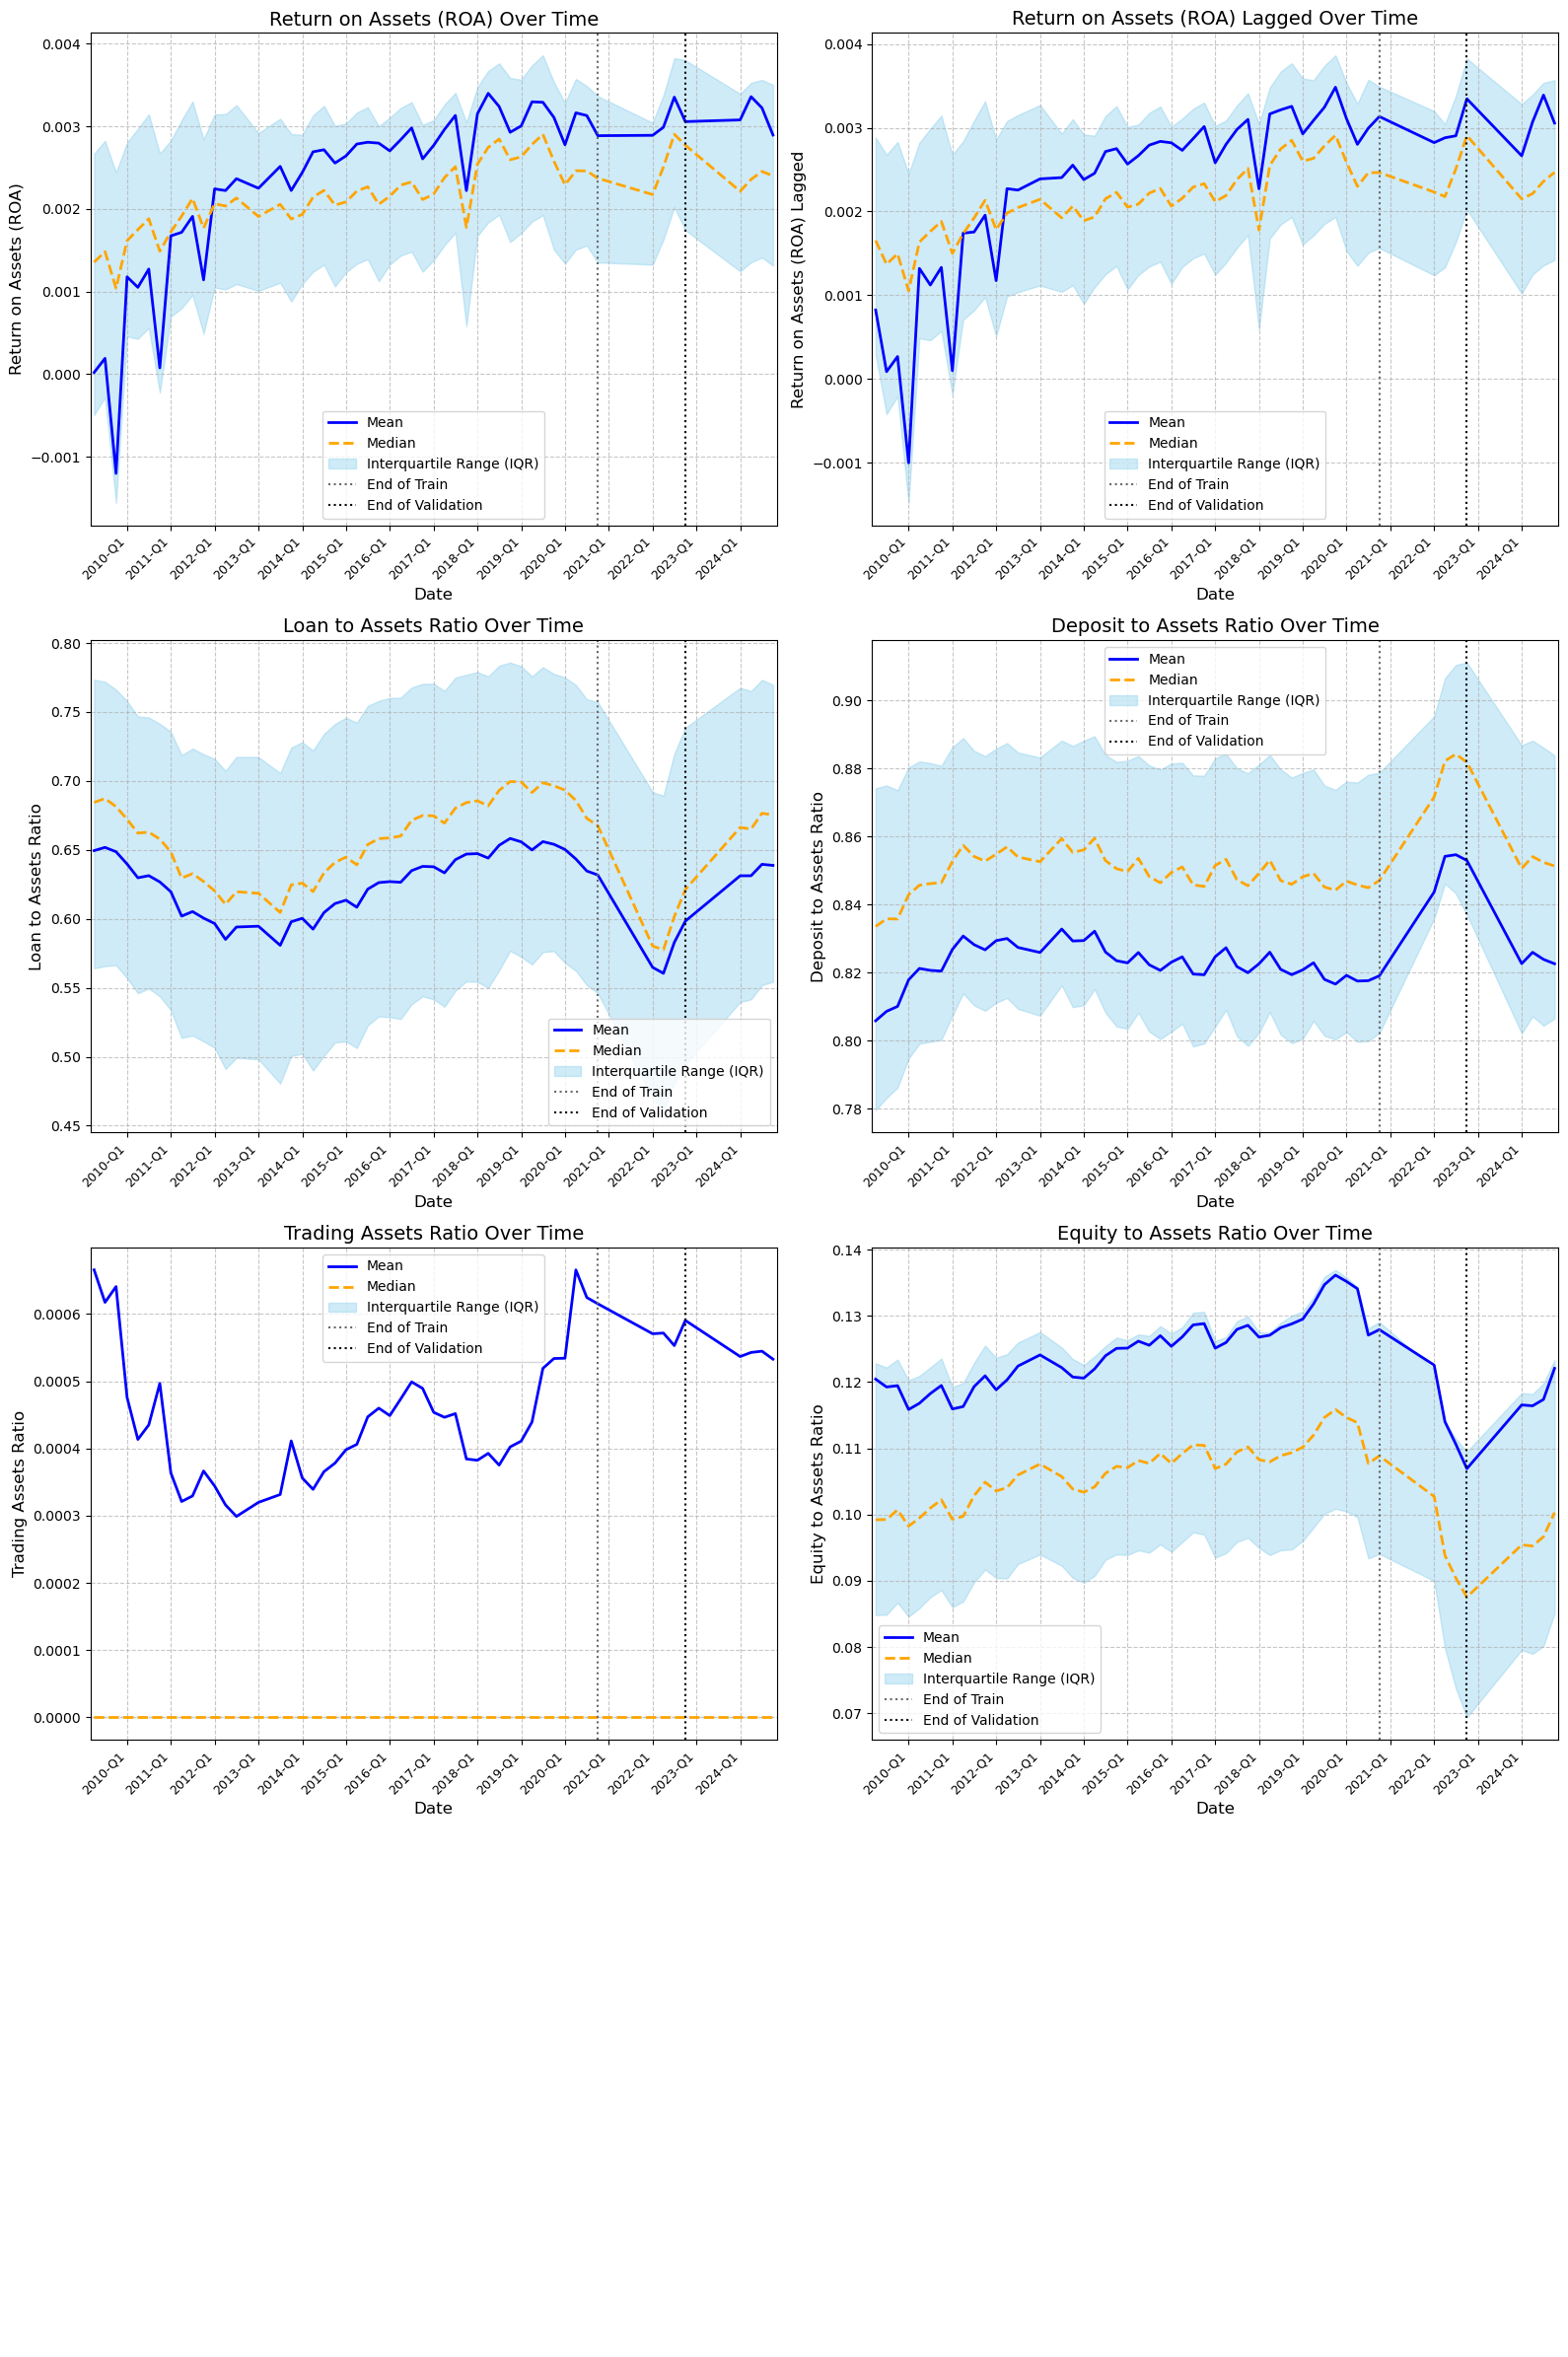

In [107]:


# --- Generate Plots ---
num_variables = len(variables_to_plot)
if num_variables == 0:
    print("No variables selected for plotting. Please update the 'variables_to_plot' dictionary.")
else:
    # Create subplots: adjust layout as needed
    # For many variables, you might want fewer columns or more rows.
    ncols = min(2, num_variables)
    nrows = (num_variables + ncols - 1) // ncols
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 8, nrows * 6), squeeze=False)
    axes = axes.flatten() # Flatten to easily iterate

    for i, (col_name, disp_name) in enumerate(variables_to_plot.items()):
        if col_name in Z.columns:
            print(f"Plotting {disp_name}...")
            plot_cross_sectional_timeseries(
                data=Z,
                column_name=col_name, # Or whatever column you're plotting
                display_name=disp_name,
                ax=axes[i],
                train_end_date=train_end_date,
                validation_end_date=val_end_date
            )
        else:
            print(f"Warning: Column '{col_name}' not found in the data. Skipping plot for '{disp_name}'.")
            if i < len(axes): # If an axis was created for it, turn it off
                 axes[i].axis('off')


    # Remove any unused subplots if the number of plots is not a perfect multiple of ncols
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

# Tests